In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'bivs.SSR'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(61056, 7)
CPU times: user 6.3 s, sys: 83.8 ms, total: 6.39 s
Wall time: 6.38 s


In [7]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,ИТАР-ТАСС со ссылкой на пресс-службу Миноборон...,Бывший СССР
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,В минувший четверг в Минске прошла самая массо...,Бывший СССР


### preprocess

* get dates

In [8]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 217 ms, sys: 6.19 ms, total: 223 ms
Wall time: 222 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [9]:
import preprocessing_tools as pr

In [10]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 9.78 s, sys: 53.1 ms, total: 9.83 s
Wall time: 9.83 s


In [11]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,итартасс со ссылкой на прессслужбу минобороны ...,Бывший СССР,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,в минувший четверг в минске прошла самая массо...,Бывший СССР,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [12]:
from cleanedNames import KeyProc
cn = KeyProc()

In [13]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 41s, sys: 80.5 ms, total: 1min 41s
Wall time: 1min 41s


* lemmatization

In [14]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 2min 27s, sys: 108 ms, total: 2min 27s
Wall time: 2min 27s


* add docID

In [15]:
df['docID'] = list(range(df.shape[0]))

In [16]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[итартасс, ссылка, прессслужба, минобороны, аз..."
1,1,1999,10,"[минувший, минск, массовый, акция, протест, ит..."


In [17]:
print(df.shape)
df.isnull().sum()

(61056, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [18]:
df.year.min()

1999

## model

* prepare

In [20]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 588 ms, sys: 112 ms, total: 700 ms
Wall time: 747 ms


In [21]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [22]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/bivs.SSR", num_batches=62)
CPU times: user 23.2 s, sys: 579 ms, total: 23.8 s
Wall time: 4.25 s


In [23]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [24]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=bbc0585a-d96f-498a-b97a-17c7828cba9e, num_entries=24178)

In [25]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

#topic 2.........
	SparsityThetaScore: 0.1356705278158188
	SparsityPhiScore: 0.23542526364326477
	PerplexityScore: 4328.91259765625
	time: 0:00:42.891542
#topic 3.........
	SparsityThetaScore: 0.23013845086097717
	SparsityPhiScore: 0.39057251811027527
	PerplexityScore: 4002.4677734375
	time: 0:00:44.776075
#topic 4.........
	SparsityThetaScore: 0.31937482953071594
	SparsityPhiScore: 0.4670107364654541
	PerplexityScore: 3681.4736328125
	time: 0:00:59.868163
#topic 5.........
	SparsityThetaScore: 0.39077240228652954
	SparsityPhiScore: 0.5273492932319641
	PerplexityScore: 3501.834716796875
	time: 0:01:10.202672
#topic 6.........
	SparsityThetaScore: 0.4416164457798004
	SparsityPhiScore: 0.5722199082374573
	PerplexityScore: 3310.90185546875
	time: 0:01:13.055424
#topic 7.........
	SparsityThetaScore: 0.48344144225120544
	SparsityPhiScore: 0.61482834815979
	PerplexityScore: 3177.38330078125
	time: 0:01:17.650177
#topic 8.........
	SparsityThetaScore: 0.5216993689537048
	SparsityPhiScore: 0.

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

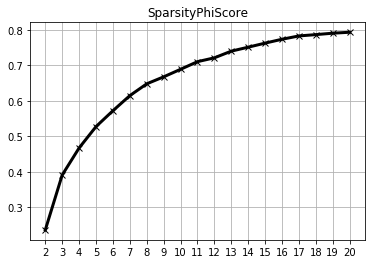

In [33]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [34]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [35]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}

Text(0.5, 1.0, 'SparsityThetaScore')

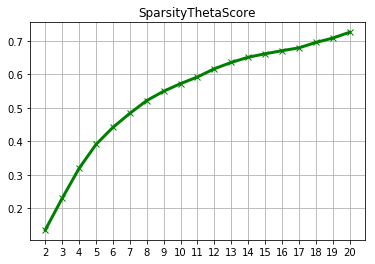

In [36]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [37]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [38]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}

Text(0.5, 1.0, 'PerplexityScore')

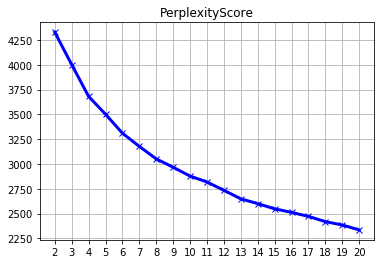

In [39]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [40]:
perplexity

[4328.91259765625,
 4002.4677734375,
 3681.4736328125,
 3501.834716796875,
 3310.90185546875,
 3177.38330078125,
 3051.691650390625,
 2967.643310546875,
 2878.2666015625,
 2818.849853515625,
 2734.997802734375,
 2649.097412109375,
 2600.837646484375,
 2548.34619140625,
 2512.116455078125,
 2472.227294921875,
 2419.25390625,
 2385.241943359375,
 2335.58740234375]

### select the best model

In [42]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}


In [43]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

20


---

In [ ]:
select_topics = 20

In [26]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.6361111402511597
	SparsityPhiScore: 0.8710460066795349
	PerplexityScore: 2521.454833984375


In [27]:
best_model = model.clone()
best_model.num_topics

20

---

### print top words for each topics

In [28]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['миллион' 'гривна' 'миллиард' 'средство' 'деньга' 'предприятие' 'сумма'
 'рубль' 'бюджет' 'цена']
topic_1: ['участник' 'митинг' 'активист' 'протест' 'оппозиция' 'беспорядок'
 'сторонник' 'площадь' 'улица' 'массовый']
topic_2: ['донецкий' 'донбасс' 'луганский' 'днр' 'самопровозгласить' 'ополченец'
 'лнр' 'донецк' 'огонь' 'прекращение']
topic_3: ['сша' 'молдавия' 'соглашение' 'ес' 'мид' 'нато' 'встреча' 'евросоюз'
 'европейский' 'подписать']
topic_4: ['кандидат' 'выборы' 'тимошенко' 'голос' 'избирательный' 'голосование'
 'президентский' 'цик' 'избиратель' 'юлия_тимошенко']
topic_5: ['самолёт' 'оборона' 'аэропорт' 'флот' 'воздушный' 'корабль' 'ракета'
 'вертолёт' 'черноморский' 'экипаж']
topic_6: ['белоруссия' 'белорусский' 'ющенко' 'минск' 'коалиция' 'блок' 'лукашенко'
 'бют' 'виктор_ющенко' 'оппозиция']
topic_7: ['взрыв' 'погибнуть' 'погибший' 'дом' 'больница' 'пострадавший' 'тело'
 'ребёнок' 'устройство' 'причина']
topic_8: ['крым' 'закон' 'латвия' 'референдум' 'законопроект'

### get topics-docs matrix

shape theta: (20, 61056)


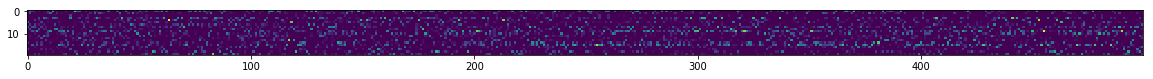

In [35]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [36]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
48000,0.143291,0.000000,0.000000,0.000000,0.0,0.015549,0.004415,0.005549,0.000000,0.0,0.124080,0.239550,0.000000,0.117372,0.000000,0.002126,0.061594,0.000000,0.014180,0.272293
48001,0.229080,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.019436,0.000000,0.0,0.112313,0.205633,0.000000,0.000000,0.000000,0.017145,0.070889,0.000000,0.017395,0.328107
48002,0.649242,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.011594,0.0,0.000000,0.088906,0.025200,0.149442,0.022437,0.000000,0.027075,0.000000,0.026104,0.000000
48003,0.048038,0.031415,0.000000,0.063973,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.011756,0.064045,0.121474,0.148335,0.000000,0.000000,0.510964,0.000000,0.000000
48004,0.000000,0.000000,0.036394,0.026618,0.0,0.000000,0.172421,0.000000,0.193541,0.0,0.000000,0.000000,0.000000,0.072715,0.039587,0.000000,0.182665,0.000000,0.000000,0.276058


## DataViz

In [37]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.0,0.0,0.000000,0.397453,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.122419,0.000000,0.000000,0.188335,0.0,0.000000
1,1,1999,10,0.300357,0.244608,0.0,0.0,0.000000,0.000000,0.171469,...,0.000000,0.045934,0.020470,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2,1999,10,0.157901,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.316278,0.000000,0.000000,0.0,0.000000
3,3,1999,10,0.050983,0.032369,0.0,0.0,0.167706,0.000000,0.190181,...,0.059465,0.000000,0.018835,0.005676,0.000000,0.000000,0.060645,0.000000,0.0,0.107708
4,4,1999,10,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.010868,...,0.000000,0.000000,0.049130,0.000000,0.143747,0.251538,0.000000,0.000000,0.0,0.000000


In [40]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 8      0.000000  0.335593  0.056426  0.139593  0.031167  0.054560   
     9      2.397280  1.251434  0.251570  2.241516  0.335456  1.025044   
     10     6.129916  2.778620  0.536843  6.215462  2.432626  2.080795   
     11     5.760758  1.500312  0.181023  6.315256  4.478013  2.981141   
     12     4.958110  1.708073  0.261937  6.055816  3.078239  1.846267   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 8      0.000000  0.119067  0.124820  0.149295  0.120913  0.163838   
     9      1.402192  2.149464  0.705262  2.249284  1.667026  1.079723   
     10     3.387941  3.642748  2.178041  7.199715  3.288961  2.790486   
     11     2.704201  2.369224  1.998718  5.349580  5.203515  2.655512   
     12     4.096073  2.749957  1.901546  2.814808  2.862959  3.106058   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 8      0.150407  0.426382  0.380723  0.251998  0.388832  0.083459   
     9      0.318194  0.198323  2.937866  2.852232  0.494452  0.470005   
     10     2.116912  1.693925  2.701624  5.894491  1.826102  1.763636   
     11     0.742977  2.351043  2.942710  3.334084  1.504391  2.025494   
     12     1.447379  3.744867  1.729093  4.375285  2.257390  1.052906   

            topic_18  topic_19  
year month                      
1999 8      0.011500  0.011425  
     9      1.148997  0.824681  
     10     3.311069  2.030088  
     11     3.556574  3.045476  
     12     2.967722  3.985518

### straightforward matrix heatmap

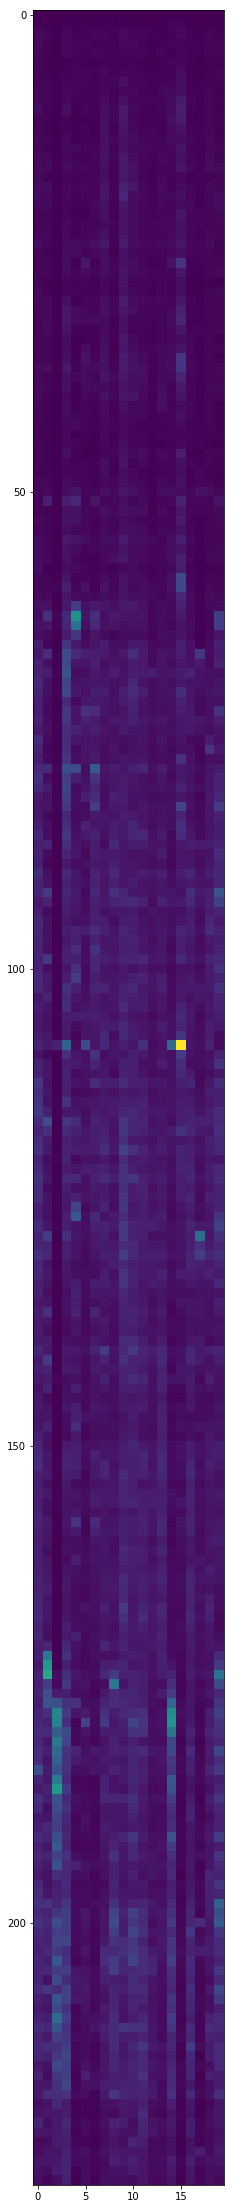

In [41]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [42]:
import pygal
from IPython.display import SVG, HTML

In [43]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [44]:
max(gb['topic_1'].values)

144.23233

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [60]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [47]:
import joypy # !pip install joypy

In [48]:
print(joined.shape)
joined.head()

(61056, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.0,0.0,0.000000,0.397453,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.122419,0.000000,0.000000,0.188335,0.0,0.000000
1,1,1999,10,0.300357,0.244608,0.0,0.0,0.000000,0.000000,0.171469,...,0.000000,0.045934,0.020470,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2,1999,10,0.157901,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.316278,0.000000,0.000000,0.0,0.000000
3,3,1999,10,0.050983,0.032369,0.0,0.0,0.167706,0.000000,0.190181,...,0.059465,0.000000,0.018835,0.005676,0.000000,0.000000,0.060645,0.000000,0.0,0.107708
4,4,1999,10,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.010868,...,0.000000,0.000000,0.049130,0.000000,0.143747,0.251538,0.000000,0.000000,0.0,0.000000


In [50]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,0,1999,10,0.000000,0.000000,0.0,0.0,0.000000,0.397453,0.000000,...,0.000000,0.000000,0.000000,0.122419,0.000000,0.000000,0.188335,0.0,0.000000,1999-10-01
1,1,1999,10,0.300357,0.244608,0.0,0.0,0.000000,0.000000,0.171469,...,0.045934,0.020470,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1999-10-01
2,2,1999,10,0.157901,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.316278,0.000000,0.000000,0.0,0.000000,1999-10-01
3,3,1999,10,0.050983,0.032369,0.0,0.0,0.167706,0.000000,0.190181,...,0.000000,0.018835,0.005676,0.000000,0.000000,0.060645,0.000000,0.0,0.107708,1999-10-01
4,4,1999,10,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.010868,...,0.000000,0.049130,0.000000,0.143747,0.251538,0.000000,0.000000,0.0,0.000000,1999-10-01


In [51]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
1,1999-10-01,topic_0,0.300357
2,1999-10-01,topic_0,0.157901
3,1999-10-01,topic_0,0.050983
5,1999-10-01,topic_0,0.058340
7,1999-10-01,topic_0,0.022711


In [52]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic             
1999-08-01 topic_1   0.335593
           topic_10  0.120913
           topic_11  0.163838
           topic_12  0.150407
           topic_13  0.426382

In [53]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,1999-08-01,topic_1,0.335593
1,1999-08-01,topic_10,0.120913
2,1999-08-01,topic_11,0.163838
3,1999-08-01,topic_12,0.150407
4,1999-08-01,topic_13,0.426382


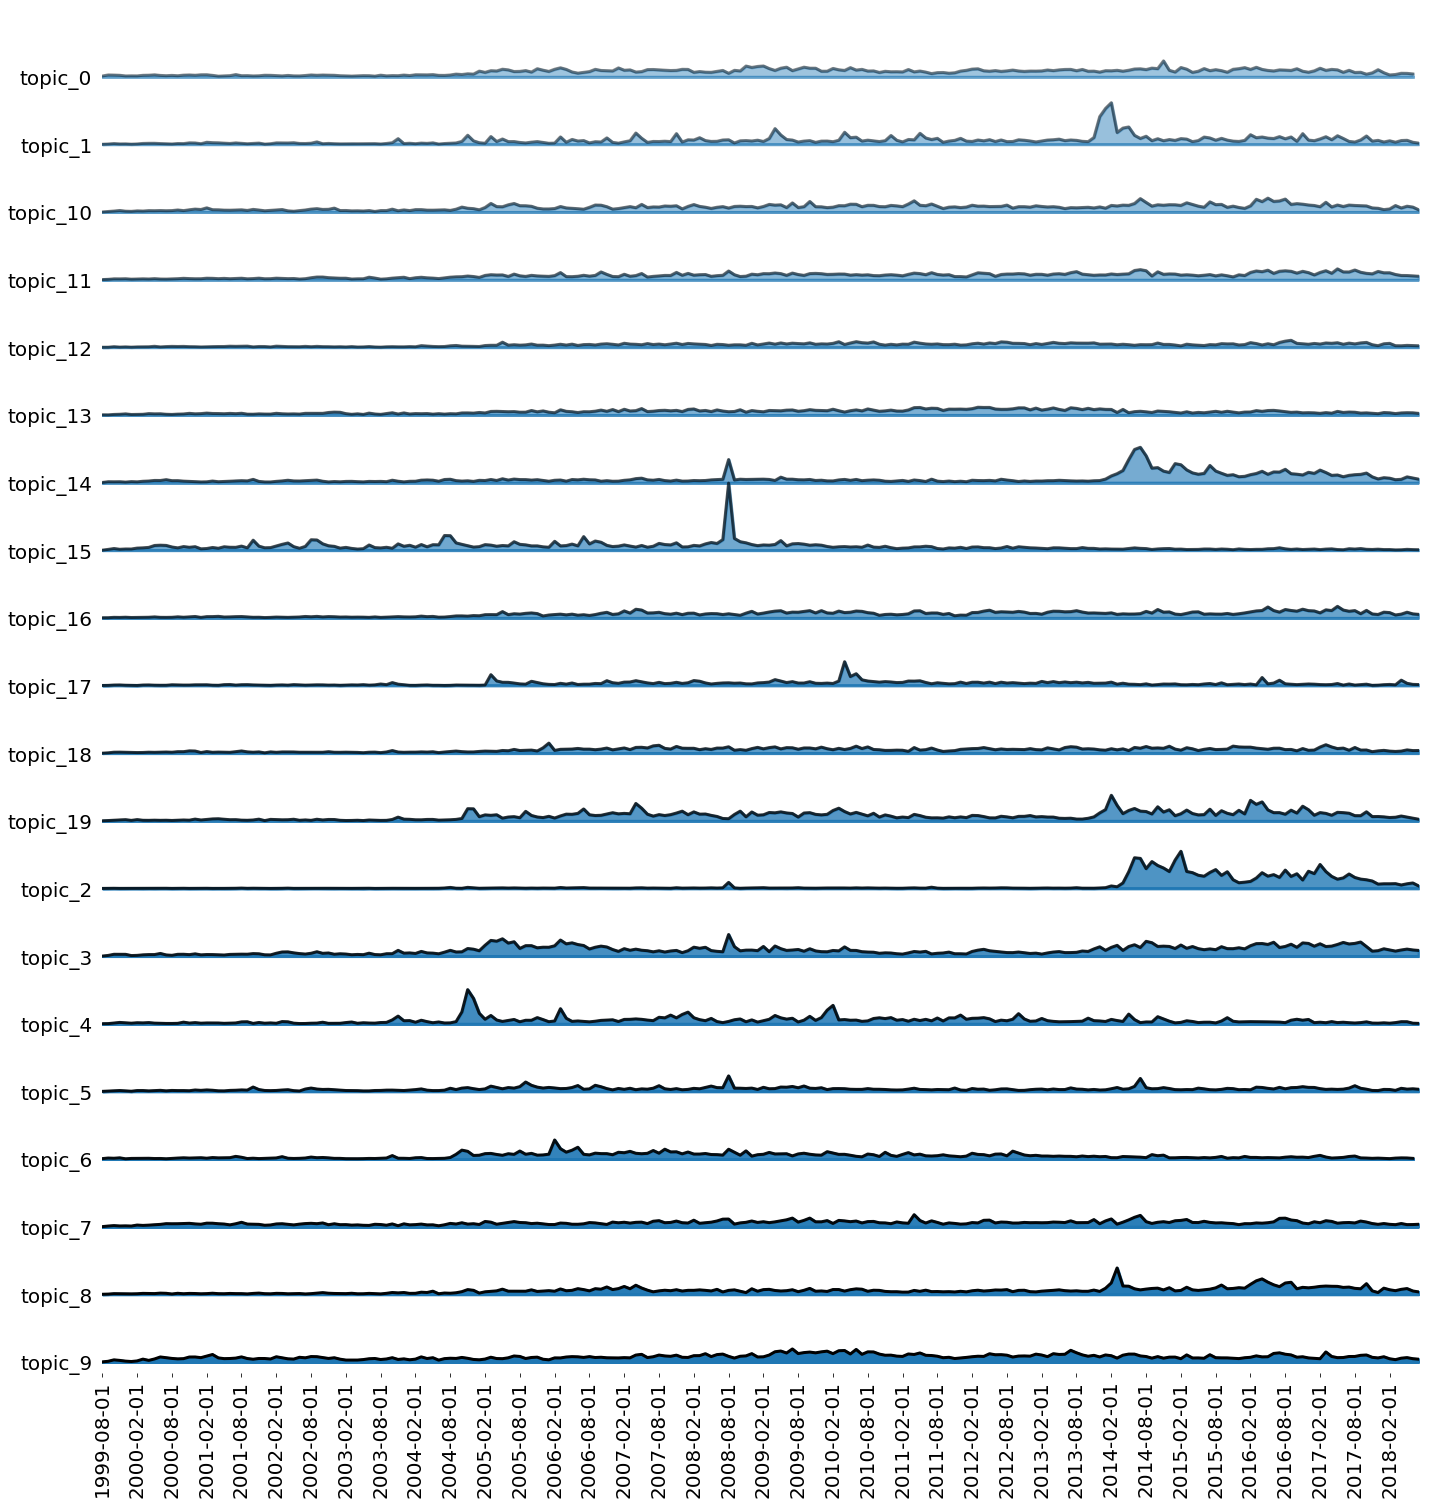

In [57]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [61]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")